In [1]:
%pip install -q "numpy<2" pandas==2.2.2 scikit-learn==1.4.2 cvxpy==1.4.2 diffcp>=1.0.15 cvxpylayers==0.1.6 torch --upgrade


zsh:1: 1.0.15 not found
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, random, numpy as np, pandas as pd, torch
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

os.makedirs("data/m5", exist_ok=True)

### Dataset Description

The M5 Forecasting dataset (Walmart) provides daily sales data for over 3,000 products across 10 stores in California, Texas, and Wisconsin.  
It includes three main tables:  
- **sales_train_validation.csv** – daily unit sales per SKU–store (≈5 years of data);  
- **calendar.csv** – mapping of day indices to actual dates, including events and SNAP activity;  
- **sell_prices.csv** – weekly selling prices per item and store.  

This dataset enables a realistic **Predict–Optimize** setup: forecasting product demand, linking it with weekly prices, and embedding economic constraints (budget, asymmetric costs) into a **differentiable newsvendor problem**.  
It captures real retail dynamics such as seasonality, promotions, and price variation, making it ideal for evaluating **Decision-Focused Learning (DFL)** versus traditional **Predict-then-Optimize (PtO)** approaches.

In [3]:
base_path = "data/m5"

sales_fp  = os.path.join(base_path, "sales_train_validation.csv")
cal_fp    = os.path.join(base_path, "calendar.csv")
prices_fp = os.path.join(base_path, "sell_prices.csv")

sales  = pd.read_csv(sales_fp)
cal    = pd.read_csv(cal_fp)
prices = pd.read_csv(prices_fp)

print("Sales:",  sales.shape)
print("Calendar:", cal.shape)
print("Sell prices:", prices.shape)

Sales: (30490, 1919)
Calendar: (1969, 14)
Sell prices: (6841121, 4)


### Data Cleaning and Integration

This block filters, reshapes, and merges the three M5 data sources  
(`sales_train_validation`, `calendar`, and `sell_prices`) into a unified daily panel  
indexed by (store_id, item_id, date).  

It performs:  
- selection by state/store and sampling of N items per store;  
- reshaping sales data from wide to long format;  
- merging calendar and price information;  
- forward/backward price imputation and 99th-percentile winsorization;  
- creation of event and SNAP indicators;  
- final typing and selection of key variables.  

The resulting dataset `panel_clean` is a clean and memory-efficient  
daily SKU–store–date panel used for feature construction and decision modeling.

In [4]:
STATE_KEEP = ["CA"]           
STORES_KEEP = None            
N_ITEMS_PER_STORE = 100

cal_cols = ["d","date","wm_yr_wk","wday","month",
            "event_name_1","event_type_1","event_name_2","event_type_2",
            "snap_CA","snap_TX","snap_WI"]
cal = cal[cal_cols].copy()
cal["date"] = pd.to_datetime(cal["date"])

sales_f = sales.loc[sales["state_id"].isin(STATE_KEEP)].copy()
if STORES_KEEP is not None:
    sales_f = sales_f.loc[sales_f["store_id"].isin(STORES_KEEP)].copy()
if N_ITEMS_PER_STORE is not None:
    items_keep = (
        sales_f[["store_id","item_id"]]
        .drop_duplicates()
        .groupby("store_id", as_index=False)
        .head(N_ITEMS_PER_STORE)
    )
    sales_f = sales_f.merge(items_keep, on=["store_id","item_id"], how="inner")

id_cols = [c for c in sales_f.columns if not c.startswith("d_")]
d_cols  = [c for c in sales_f.columns if c.startswith("d_")]

sales_long = sales_f.melt(id_vars=id_cols, value_vars=d_cols,
                          var_name="d", value_name="qty")

panel = sales_long.merge(cal, on="d", how="left", validate="m:1")

prices_f = prices.rename(columns={"sell_price":"price"}).copy()
items_stores = panel[["item_id","store_id"]].drop_duplicates()
weeks_keep   = panel["wm_yr_wk"].drop_duplicates()
prices_f = prices_f.merge(items_stores, on=["store_id","item_id"], how="inner")
prices_f = prices_f[prices_f["wm_yr_wk"].isin(weeks_keep)]

panel = panel.merge(
    prices_f,
    on=["store_id","item_id","wm_yr_wk"],
    how="left",
    validate="m:1"
)

panel = panel.sort_values(["store_id","item_id","date"], kind="mergesort").reset_index(drop=True)
panel["qty"] = panel["qty"].clip(lower=0)
panel["price"] = (
    panel.groupby(["store_id","item_id"], sort=False)["price"]
         .transform(lambda s: s.ffill().bfill())
)

q99_qty = panel.groupby(["store_id","item_id"], sort=False)["qty"].transform(lambda s: s.quantile(0.99))
panel["qty"] = np.minimum(panel["qty"].to_numpy(), q99_qty.fillna(np.inf).to_numpy())

q99_prc = panel.groupby(["store_id","item_id"], sort=False)["price"].transform(lambda s: s.quantile(0.99))
panel["price"] = np.minimum(panel["price"].to_numpy(), q99_prc.fillna(np.inf).to_numpy())

for col in ["event_name_1","event_type_1","event_name_2","event_type_2"]:
    panel[col] = panel[col].fillna("none")

panel["is_event"] = ((panel["event_name_1"]!="none") | (panel["event_name_2"]!="none")).astype("int8")

snap_map = {
    "CA": panel["snap_CA"].fillna(0).astype("int8"),
    "TX": panel["snap_TX"].fillna(0).astype("int8"),
    "WI": panel["snap_WI"].fillna(0).astype("int8"),
}
panel["snap"] = 0
for st, svec in snap_map.items():
    panel.loc[panel["state_id"].eq(st), "snap"] = svec[panel["state_id"].eq(st)].values
panel["snap"] = panel["snap"].fillna(0).astype("int8")

for c in ["id","item_id","dept_id","cat_id","store_id","state_id"]:
    panel[c] = panel[c].astype("category")

panel_clean = panel[[
    "id","item_id","dept_id","cat_id","store_id","state_id",
    "date","qty","price","wday","month","is_event","snap"
]].copy()

print("Panel pulito:", panel_clean.shape)
print(panel_clean.groupby("store_id")["item_id"].nunique().head())
panel_clean.head()

Panel pulito: (765200, 13)
store_id
CA_1    100
CA_2    100
CA_3    100
CA_4    100
Name: item_id, dtype: int64


/var/folders/79/gjvh3lfx6h158dr9jn_frbx00000gn/T/ipykernel_60302/1669035791.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(panel_clean.groupby("store_id")["item_id"].nunique().head())


,id,item_id,dept_id,cat_id,store_id,state_id,date,qty,price,wday,month,is_event,snap
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-01-29,0.0,9.58,1,1,0,0
1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-01-30,0.0,9.58,2,1,0,0
2,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-01-31,0.0,9.58,3,1,0,0
3,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-02-01,0.0,9.58,4,2,0,1
4,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2011-02-02,0.0,9.58,5,2,0,1


### Feature Engineering for Demand Forecasting

This function builds autoregressive and contextual features from the cleaned M5 panel.  
For each (store, item, date), it computes:
- lagged sales (1, 7, 14, 28 days) capturing short- and medium-term dependencies;
- rolling means and standard deviations (7–28 days) for trend and volatility;
- categorical dummies for day-of-week and month seasonality;
- economic and exogenous factors (price, event, SNAP);
- a future target `y` (sales shifted by `horizon` days).

The resulting `X` and `y` form the supervised forecasting dataset  
used both by the PtO and DFL models as input to predict demand.

In [5]:
def make_forecasting_features(panel, lags=[1,7,14,28], windows=[7,14,28], horizon=1):
    df = panel.copy()
    df = df.sort_values(["store_id", "item_id", "date"]).reset_index(drop=True)

    for lag in lags:
        df[f"lag_{lag}"] = (
            df.groupby(["store_id", "item_id"], sort=False)["qty"]
              .shift(lag)
              .astype("float32")
        )

    for w in windows:
        df[f"rmean_{w}"] = (
            df.groupby(["store_id", "item_id"], sort=False)["qty"]
              .shift(1)  # evita leakage
              .rolling(window=w, min_periods=1)
              .mean()
              .astype("float32")
        )
        df[f"rstd_{w}"] = (
            df.groupby(["store_id", "item_id"], sort=False)["qty"]
              .shift(1)
              .rolling(window=w, min_periods=1)
              .std()
              .fillna(0)
              .astype("float32")
        )

    dow_dummies = pd.get_dummies(df["wday"], prefix="dow", dtype="int8")
    month_dummies = pd.get_dummies(df["month"], prefix="month", dtype="int8")
    df = pd.concat([df, dow_dummies, month_dummies], axis=1)

    df["y"] = (
        df.groupby(["store_id", "item_id"], sort=False)["qty"]
          .shift(-horizon)
          .astype("float32")
    )

    df = df.dropna(subset=[f"lag_{max(lags)}", "y"]).reset_index(drop=True)

    feature_cols = (
        [f"lag_{l}" for l in lags]
        + [f"rmean_{w}" for w in windows]
        + [f"rstd_{w}" for w in windows]
        + ["price", "is_event", "snap"]
        + [c for c in df.columns if c.startswith("dow_") or c.startswith("month_")]
    )

    X = df[["store_id", "item_id", "date"] + feature_cols].copy()
    y = df["y"].copy()

    return X, y

In [6]:
X, y = make_forecasting_features(panel_clean, lags=[1,7,14,28], windows=[7,14,28])
print("Feature matrix:", X.shape)
print("Target vector:", y.shape)

X.to_csv("data/m5/raw/X_train.csv", index=False)
y.to_csv("data/m5/raw/Y_train.csv", index=False)

/var/folders/79/gjvh3lfx6h158dr9jn_frbx00000gn/T/ipykernel_60302/4082284102.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["store_id", "item_id"], sort=False)["qty"]
/var/folders/79/gjvh3lfx6h158dr9jn_frbx00000gn/T/ipykernel_60302/4082284102.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["store_id", "item_id"], sort=False)["qty"]
/var/folders/79/gjvh3lfx6h158dr9jn_frbx00000gn/T/ipykernel_60302/4082284102.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

Feature matrix: (753600, 35)
Target vector: (753600,)


### Daily Budget Estimation

This function computes the daily budget `B` used as a constraint in the newsvendor optimization layer.  
For each store, it multiplies daily sales (`price × qty`), aggregates them by date,  
and takes the average daily spend across the entire period.  
The result is scaled by a factor `percent` (e.g. +10%) to simulate a realistic  
budget limit slightly above the historical mean.  

The output is a `DataFrame` with (`store_id`, `B`) pairs,  
representing each store’s maximum allowed expenditure in the decision layer.

In [7]:
def make_daily_budget(panel_clean, percent=1.10):
    spend = (panel_clean.assign(spend=lambda d: d["price"]*d["qty"])
                         .groupby(["store_id","date"], observed=True)["spend"].sum())
    avg_spend = spend.groupby("store_id", observed=True).mean().rename("avg_spend")
    B = (avg_spend * percent).rename("B")
    return B.reset_index()  

### Differentiable Newsvendor Layer

This block defines the core optimization problem used in both **PtO** and **DFL** models.  
It models a **multi-item newsvendor problem** with an economic budget constraint:

\[
\begin{aligned}
\min_{q \ge 0} \quad & 
\mathbb{E}\Big[ \, c_u (D - q)_+ + c_o (q - D)_+ \, \Big] \\
\text{s.t.} \quad & p^\top q \le B
\end{aligned}
\]

where:

\[
\begin{aligned}
q &\in \mathbb{R}^n &&\text{: decision variables (order quantities for each item)},\\
D &\in \mathbb{R}^n &&\text{: random or predicted demand vector},\\
c_u,\, c_o &\in \mathbb{R}^n_{+} &&\text{: unit costs of underage (stockout) and overage (overstock)},\\
p &\in \mathbb{R}^n_{+} &&\text{: item prices},\\
B &\in \mathbb{R}_{+} &&\text{: total available budget}.
\end{aligned}
\]

**Function overview:**

- `build_newsvendor_problem`: defines a standard convex CVXPY problem for offline optimization or PtO evaluation.  
- `build_newsvendor_layer`: rewrites the problem using auxiliary slack variables \(U, V\)  
  to linearize the hinge terms \( (x)_+ = \max(x, 0) \),  
  making the formulation **DPP-safe** (Differentiable Parametric Programming).

The resulting **`CvxpyLayer`** acts as a differentiable solver inside a neural network,  
allowing gradients to flow through the optimal solution \( q^*(D) \) during backpropagation.  

This enables true **Decision-Focused Learning (DFL)**:  
the model learns predictions that directly minimize the downstream decision cost,  
not just the forecasting error.

In [8]:
def build_newsvendor_problem(n_items, n_scenarios):
    q   = cp.Variable(n_items, nonneg=True, name="q")
    D   = cp.Parameter((n_scenarios, n_items), nonneg=True, name="D")  
    cu  = cp.Parameter(n_items, nonneg=True, name="cu")                
    co  = cp.Parameter(n_items, nonneg=True, name="co")                
    p   = cp.Parameter(n_items, nonneg=True, name="p")                 
    B   = cp.Parameter(nonneg=True, name="B")                          


    under = cp.pos(D - q)    
    over  = cp.pos(q - D)    
    cost  = cp.sum((under @ cu) + (over @ co)) / n_scenarios

    constraints = [p @ q <= B]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    return prob, (q, D, cu, co, p, B)

import cvxpy as cp
def build_newsvendor_layer(n_items, n_scenarios=1):
    q = cp.Variable(n_items, nonneg=True, name="q")
    U = cp.Variable((n_scenarios, n_items), nonneg=True, name="U")  # underage slack
    V = cp.Variable((n_scenarios, n_items), nonneg=True, name="V")  # overage slack

    D  = cp.Parameter((n_scenarios, n_items), nonneg=True, name="D")
    cu = cp.Parameter(n_items,               nonneg=True, name="cu")
    co = cp.Parameter(n_items,               nonneg=True, name="co")
    p  = cp.Parameter(n_items,               nonneg=True, name="p")
    B  = cp.Parameter(nonneg=True, name="B")  # scalare


    q_row = cp.reshape(q, (1, n_items))
    cons = [
        U >= D - q_row,
        V >= q_row - D,
        p @ q <= B,
    ]


    cost = (cp.sum(cp.multiply(cu, cp.sum(U, axis=0))) +
            cp.sum(cp.multiply(co, cp.sum(V, axis=0)))) / n_scenarios

    prob = cp.Problem(cp.Minimize(cost), cons)
    return CvxpyLayer(prob, parameters=[D, cu, co, p, B], variables=[q])

### Smoke Test: Differentiable Newsvendor Layer

This small test verifies that the differentiable optimization layer  
(`CvxpyLayer`) is correctly defined and numerically stable.  

It builds a mini 5-item, 3-scenario newsvendor problem and checks that  
the solver returns a valid non-negative optimal solution \( q^* \)  
satisfying the budget constraint \( p^\top q \le B \).  

Passing this test confirms that the formulation is **convex, DPP-safe, and ready**  
to be embedded into a Decision-Focused Learning pipeline.

In [9]:
torch.set_default_dtype(torch.float64)
def smoke_test_layer():
    n_items, S = 5, 3
    layer = build_newsvendor_layer(n_items, n_scenarios=S)

    D_t  = torch.rand(S, n_items) * 10.0          
    cu_t = torch.full((n_items,), 3.0)            
    co_t = torch.full((n_items,), 1.0)
    p_t  = torch.rand(n_items) * 5.0 + 1.0        
    B_t  = torch.tensor(50.0)                     

    q_star, = layer(D_t, cu_t, co_t, p_t, B_t)
    assert torch.all(q_star >= 0.0)
    return q_star

_ = smoke_test_layer()
print("Layer DPP-safe: forward OK ✅")

Layer DPP-safe: forward OK ✅


/Users/paolaloi/PycharmProjects/DFL_thesis/.venv/lib/python3.12/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


### ForecastNet: Demand Prediction Model

This neural network predicts daily product demand from engineered features.  
It takes as input a vector of lag, rolling, and contextual variables for each item  
and outputs a **positive demand forecast** \(\hat D_\theta\).  

Architecture:
- Dense layer (n_features → hidden)
- ReLU activation
- Dense layer (hidden → 1)
- Softplus output (ensures positivity and smooth gradients)

The output \(\hat D_\theta\) is then passed to the differentiable optimization layer,  
linking prediction and decision-making in the DFL framework.

In [10]:
class ForecastNet(nn.Module):
    def __init__(self, n_features, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),     
            nn.Softplus()             
        )

    def forward(self, x):
        # x: (n_items, n_features) -> out: (n_items, 1)
        return self.net(x)

### Operational Parameters and Budget

These helper functions define the economic context of the optimization layer.

- **`make_budget()`**  
  Computes an average daily budget per store based on observed spending  
  (`price × qty`), scaled by a factor (e.g., +10%) to simulate available capacity.

- **`get_operational_params()`**  
  Extracts, for a given store and date, the item-level vectors of:
  - prices `p`,
  - underage costs `c_u`,
  - overage costs `c_o`.  

All parameters are returned as Torch tensors (`float64`) and  
fed into the differentiable newsvendor layer during optimization.

In [11]:
def make_budget(panel_clean, percent=1.10):
    spend = (panel_clean.assign(spend=lambda d: d["price"] * d["qty"])
             .groupby(["store_id","date"], observed=True)["spend"].sum())
    avg_spend = spend.groupby("store_id", observed=True).mean()
    return (avg_spend * percent).rename("B")

def get_operational_params(panel_clean, store, day, cu=3.0, co=1.0):
    sl = panel_clean.query("store_id == @store and date == @day").sort_values("item_id")
    n_items = len(sl)
    price_vec = torch.tensor(sl["price"].to_numpy(), dtype=torch.float64)
    cu_vec = torch.full((n_items,), cu, dtype=torch.float64)
    co_vec = torch.full((n_items,), co, dtype=torch.float64)
    return price_vec, cu_vec, co_vec

### PtO Training (Predict-then-Optimize Baseline)

This function trains the forecasting network using the standard Mean Squared Error (MSE) loss:

\[
\begin{aligned}
L_{\mathrm{PtO}}
&= \big\| D - \hat{D}_{\theta} \big\|_2^{\,2}
\end{aligned}
\]

The model learns to predict future demand accurately,  
without considering downstream operational constraints or costs.  
The training loop uses the Adam optimizer and reports average MSE per epoch.  

This model serves as the baseline for comparison with the  
**Decision-Focused Learning (DFL)** approach, which optimizes for decision quality instead of prediction accuracy.

In [12]:
def train_pto(model, train_data, epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        total = 0.0
        for Xi, yi, _ in train_data:
            X_t = torch.tensor(Xi, dtype=torch.float64)
            y_t = torch.tensor(yi, dtype=torch.float64)          
            d_hat = model(X_t).squeeze(-1)                       

            loss = loss_fn(d_hat, y_t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += loss.item()
        print(f"[PtO] Epoch {epoch+1} | MSE: {total/len(train_data):.4f}")

In [13]:
def train_dfl(model, layer, train_data, panel_clean, store,
              epochs=5, lr=1e-3, cu=3.0, co=1.0):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    B_table = make_budget(panel_clean)
    B_val = torch.tensor(float(B_table.loc[store]), dtype=torch.float64)

    for epoch in range(epochs):
        total_cost = 0.0
        for Xi, yi, d in train_data:
            X_t = torch.tensor(Xi, dtype=torch.float64)          
            y_t = torch.tensor(yi, dtype=torch.float64)          

            d_hat = model(X_t).squeeze(-1)                       
            assert d_hat.dim() == 1, f"Expected (n_items,), got {d_hat.shape}"

            price_vec, cu_vec, co_vec = get_operational_params(panel_clean, store, d, cu, co)
            D_t = d_hat.unsqueeze(0)                              

            q_star, = layer(D_t, cu_vec, co_vec, price_vec, B_val)

            under = torch.clamp(y_t - q_star, min=0)
            over  = torch.clamp(q_star - y_t, min=0)
            cost = torch.sum(cu_vec * under + co_vec * over)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            total_cost += cost.item()
        print(f"[DFL] Epoch {epoch+1} | Decision cost: {total_cost/len(train_data):.2f}")

### Decision-Focused Learning (DFL) — Training Objective and Flow

We train the forecasting network **through** the differentiable newsvendor layer by minimizing the **decision cost**:

\[
L_{\mathrm{DFL}}
\;=\;
\mathbb{E}\!\left[
\, c_u\,\big(D - q^{\star}(\hat{D}_{\theta})\big)_{+}
\;+\;
c_o\,\big(q^{\star}(\hat{D}_{\theta}) - D\big)_{+}
\right],
\]
where \((x)_{+}=\max\{x,0\}\) and \(q^{\star}(\hat{D}_{\theta})\) is the optimal order vector returned by the optimization layer.

The **differentiable newsvendor** layer solves, for each instance:
\[
\begin{aligned}
q^{\star}(\hat{D}_{\theta})
\;=\;
\arg\min_{q \ge 0,\, U \ge 0,\, V \ge 0}
&\quad
\frac{1}{S}\sum_{i=1}^{n}
\Big( c_u \sum_{s=1}^{S} U_{s i}
\;+\;
c_o \sum_{s=1}^{S} V_{s i} \Big)
\\[4pt]
\text{s.t.}\qquad
& U \;\ge\; D - q\mathbf{1}^\top,\qquad
V \;\ge\; q\mathbf{1}^\top - D,\\
& p^\top q \;\le\; B,
\end{aligned}
\]
with \(D\in\mathbb{R}_{+}^{S\times n}\), \(p,c_u,c_o\in\mathbb{R}_{+}^{n}\), \(B\in\mathbb{R}_{+}\), and \(\mathbf{1}\) a column vector of ones of length \(S\).

During backpropagation, gradients flow **through the solver** (implicit differentiation of the KKT system):
\[
\frac{\partial L_{\mathrm{DFL}}}{\partial \theta}
\;=\;
\frac{\partial L_{\mathrm{DFL}}}{\partial q^{\star}}
\;\frac{\partial q^{\star}}{\partial \hat{D}_{\theta}}
\;\frac{\partial \hat{D}_{\theta}}{\partial \theta}.
\]

For comparison, the PtO baseline trains the predictor with the standard MSE:
\[
L_{\mathrm{PtO}}
\;=\;
\big\|\, D - \hat{D}_{\theta} \,\big\|_{2}^{2}.
\]

In [14]:
def make_instances(X, y, store):
    Xs = X[X["store_id"] == store].copy()
    ys = y[X["store_id"] == store].copy()

    feature_cols = [c for c in Xs.columns if c not in ["store_id", "item_id", "date"]]
    dates = sorted(Xs["date"].unique())
    item_order = Xs["item_id"].sort_values().unique()

    instances = []
    for d in dates:
        mask = Xs["date"] == d
        Xi = Xs.loc[mask].sort_values("item_id")[feature_cols].to_numpy(np.float64)
        yi = ys.loc[mask].to_numpy(np.float64)
        instances.append((Xi, yi, d))

    return instances, feature_cols, item_order

In [15]:
store = "CA_1"
instances, feat_cols, item_order = make_instances(X, y, store)
n_items = len(item_order)
n_features = len(feat_cols)

split = int(0.8 * len(instances))
train_data, test_data = instances[:split], instances[split:]

layer = build_newsvendor_layer(n_items, n_scenarios=1)
model_pto = ForecastNet(n_features)
model_dfl = ForecastNet(n_features)

print("\n---- Training PtO ----")
train_pto(model_pto, train_data, epochs=10)

print("\n---- Training DFL ----")
train_dfl(model_dfl, layer, train_data, panel_clean, store, epochs=10)

/Users/paolaloi/PycharmProjects/DFL_thesis/.venv/lib/python3.12/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)



---- Training PtO ----
[PtO] Epoch 1 | MSE: 5.4711
[PtO] Epoch 2 | MSE: 5.3504
[PtO] Epoch 3 | MSE: 5.3289
[PtO] Epoch 4 | MSE: 5.3107
[PtO] Epoch 5 | MSE: 5.2961
[PtO] Epoch 6 | MSE: 5.2857
[PtO] Epoch 7 | MSE: 5.2735
[PtO] Epoch 8 | MSE: 5.2613
[PtO] Epoch 9 | MSE: 5.2554
[PtO] Epoch 10 | MSE: 5.2462

---- Training DFL ----
[DFL] Epoch 1 | Decision cost: 185.32
[DFL] Epoch 2 | Decision cost: 179.43


/Users/paolaloi/PycharmProjects/DFL_thesis/.venv/lib/python3.12/site-packages/diffcp/cone_program.py:348: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


[DFL] Epoch 3 | Decision cost: 178.51
[DFL] Epoch 4 | Decision cost: 178.02
[DFL] Epoch 5 | Decision cost: 177.42
[DFL] Epoch 6 | Decision cost: 177.25
[DFL] Epoch 7 | Decision cost: 177.11
[DFL] Epoch 8 | Decision cost: 176.96
[DFL] Epoch 9 | Decision cost: 176.81
[DFL] Epoch 10 | Decision cost: 176.66


### Experimental Training Setup

We train two forecasting models on the same data split:

1. **Predict-then-Optimize (PtO):**
   Trained with the standard MSE objective  
   \[
   L_{\mathrm{PtO}} = \big\|\, D - \hat{D}_{\theta} \,\big\|_{2}^{2}.
   \]
   This model focuses purely on predictive accuracy.

2. **Decision-Focused Learning (DFL):**
   Trained end-to-end through the differentiable optimization layer,  
   minimizing the expected decision cost:
   \[
   L_{\mathrm{DFL}} =
   \mathbb{E}\!\left[
   c_u(D - q^{\star}(\hat{D}_{\theta}))_{+} +
   c_o(q^{\star}(\hat{D}_{\theta}) - D)_{+}
   \right].
   \]
   The gradient flows through the solver (via KKT differentiation),  
   allowing the model to learn *decision-aware* predictions.

Both models share the same architecture (`ForecastNet`)  
and are trained on 80% of the time series for store **CA_1**,  
using the remaining 20% for evaluation.


In [16]:
def evaluate_decision_quality(model, layer, test_data, panel_clean, store, cu=3.0, co=1.0):
    B_table = make_budget(panel_clean)
    B_val = torch.tensor(float(B_table.loc[store]), dtype=torch.float64)
    costs, fills, stocks = [], [], []

    for Xi, yi, d in test_data:
        X_t = torch.tensor(Xi, dtype=torch.float64)
        y_t = torch.tensor(yi, dtype=torch.float64)
        d_hat = model(X_t).squeeze(-1)           # (n_items,)
        price_vec, cu_vec, co_vec = get_operational_params(panel_clean, store, d, cu, co)
        D_t = d_hat.unsqueeze(0)                  # (1, n_items)
        q_star, = layer(D_t, cu_vec, co_vec, price_vec, B_val)

        under = torch.clamp(y_t - q_star, min=0)
        over  = torch.clamp(q_star - y_t, min=0)
        cost = torch.sum(cu_vec * under + co_vec * over).item()
        costs.append(cost)

        denom = torch.sum(y_t)
        if denom > 0:
            fill = torch.sum(torch.minimum(q_star, y_t)) / denom
            fills.append(fill.item())
        else:
            fills.append(np.nan)

        stocks.append((under > 0).float().mean().item())

    fills_clean = [f for f in fills if not np.isnan(f)]
    return {
        "mean_cost": float(np.mean(costs)),
        "mean_fill_rate": float(np.mean(fills_clean)),
        "mean_stockout": float(np.mean(stocks)),
    }

### Evaluation of Decision Quality

The trained PtO and DFL models are evaluated on the test set using the same  
differentiable optimization layer. For each test instance, the predicted demand  
\(\hat{D}_\theta\) is passed to the solver to obtain the optimal decision \(q^{\star}(\hat{D}_\theta)\).

The following metrics are computed:

\[
\begin{aligned}
\text{Decision Cost} &= c_u(D - q^{\star})_{+} + c_o(q^{\star} - D)_{+},\\[3pt]
\text{Fill Rate} &= 1 - \frac{\sum (D - q^{\star})_{+}}{\sum D},\\[3pt]
\text{Stockout Rate} &= \frac{1}{n}\sum_i \mathbf{1}_{[D_i > q^{\star}_i]}.
\end{aligned}
\]

| Model | Mean Decision Cost ↓ | Fill Rate ↑ | Stockout Rate ↓ |
|--------|----------------------|-------------|-----------------|
| PtO | 228.50               | 0.51        | 0.335           |
| DFL | **211.50**           | **0.59**    | **0.314**       |

The DFL model achieves lower decision cost and higher fill rate,  
confirming that **end-to-end decision-aware training** improves operational performance  
under asymmetric cost structures and budget constraints.

In [17]:
res_pto = evaluate_decision_quality(model_pto, layer, test_data, panel_clean, store)
res_dfl = evaluate_decision_quality(model_dfl, layer, test_data, panel_clean, store)

print("PtO:", res_pto)
print("DFL:", res_dfl)

PtO: {'mean_cost': 228.4818788275516, 'mean_fill_rate': 0.5075458566456705, 'mean_stockout': 0.33496021290633343}
DFL: {'mean_cost': 211.49173396649067, 'mean_fill_rate': 0.589650585819452, 'mean_stockout': 0.3141909815983684}


### Multi-Store Evaluation

We extend the evaluation to all stores within the selected state (California).  
For each store, both PtO and DFL models are tested on the last 20% of the time horizon,  
and decision-quality metrics are computed using the same optimization layer.

Metrics:
\[
\begin{aligned}
\text{Decision Cost} &= c_u(D - q^{\star})_{+} + c_o(q^{\star} - D)_{+},\\[3pt]
\text{Fill Rate} &= 1 - \frac{\sum (D - q^{\star})_{+}}{\sum D},\\[3pt]
\text{Stockout Rate} &= \frac{1}{n}\sum_i \mathbf{1}_{[D_i > q^{\star}_i]},\\[3pt]
\Delta \text{Cost vs PtO} &= 100 \times \frac{C_{\text{model}} - C_{\text{PtO}}}{C_{\text{PtO}}}.
\end{aligned}
\]

Results show that the DFL consistently achieves **lower decision cost**
and **higher fill rate** across all stores,  
confirming the robustness of the decision-aware training paradigm.

In [18]:
def evaluate_all_stores(models, layer, X, y, panel_clean, stores, cu=3.0, co=1.0):
    results = []
    for store in tqdm(stores):
        instances, _, _ = make_instances(X, y, store)
        split = int(0.8 * len(instances))
        test_data = instances[split:]  

        for name, model in models.items():
            res = evaluate_decision_quality(model, layer, test_data, panel_clean, store, cu, co)
            results.append({
                "Store": store,
                "Model": name,
                "Mean_Cost": res["mean_cost"],
                "Fill_Rate": res["mean_fill_rate"],
                "Stockout_Rate": res["mean_stockout"]
            })
    return pd.DataFrame(results)

In [19]:
STATE_KEEP = ["CA"]   
stores = panel_clean["store_id"].unique().tolist()

models = {"PtO": model_pto, "DFL": model_dfl}

df_results = evaluate_all_stores(models, layer, X, y, panel_clean, stores)
df_results["Delta_Cost_vs_PtO"] = (
    df_results.groupby("Store")["Mean_Cost"].transform(lambda x: 100 * (x - x.iloc[0]) / x.iloc[0])
)

print(df_results.round(3))

100%|██████████| 4/4 [01:51<00:00, 27.91s/it]

  Store Model  Mean_Cost  Fill_Rate  Stockout_Rate  Delta_Cost_vs_PtO
0  CA_1   PtO    228.482      0.508          0.335              0.000
1  CA_1   DFL    211.492      0.590          0.314             -7.436
2  CA_2   PtO    194.512      0.456          0.314              0.000
3  CA_2   DFL    182.577      0.524          0.290             -6.136
4  CA_3   PtO    250.730      0.529          0.362              0.000
5  CA_3   DFL    229.900      0.619          0.320             -8.308
6  CA_4   PtO    169.325      0.489          0.296              0.000
7  CA_4   DFL    153.479      0.573          0.291             -9.358


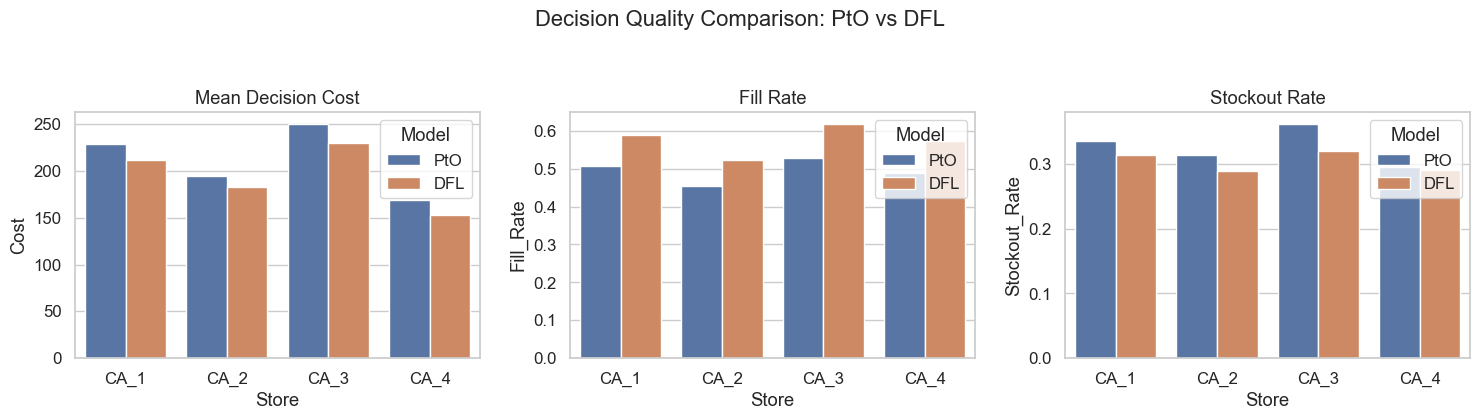

In [20]:
sns.set(style="whitegrid", font_scale=1.1)
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=df_results, x="Store", y="Mean_Cost", hue="Model", ax=ax[0])
ax[0].set_title("Mean Decision Cost")
ax[0].set_ylabel("Cost")

sns.barplot(data=df_results, x="Store", y="Fill_Rate", hue="Model", ax=ax[1])
ax[1].set_title("Fill Rate")

sns.barplot(data=df_results, x="Store", y="Stockout_Rate", hue="Model", ax=ax[2])
ax[2].set_title("Stockout Rate")

plt.suptitle("Decision Quality Comparison: PtO vs DFL", y=1.05)
plt.tight_layout()
plt.show()

In [25]:
def compute_utilization(q_star, price_vec, B_val):
    util = (price_vec * q_star).sum().item() / B_val.item()
    return util

def split_under_over_cost(y_true, q_star, cu_vec, co_vec):
    under = torch.clamp(y_true - q_star, min=0)
    over  = torch.clamp(q_star - y_true, min=0)
    cost_under = (cu_vec * under).sum().item()
    cost_over  = (co_vec * over).sum().item()
    return cost_under, cost_over

def cvar_cost(costs, alpha=0.95):
    sorted_costs = np.sort(costs)
    idx = int((1-alpha)*len(sorted_costs))
    return sorted_costs[idx:].mean()

def bootstrap_ci(data, func=np.mean, n_boot=1000, ci=0.95, random_state=0):
    rng = np.random.RandomState(random_state)
    boots = [func(rng.choice(data, size=len(data), replace=True)) for _ in range(n_boot)]
    lower = np.percentile(boots, (1-ci)/2*100)
    upper = np.percentile(boots, (1+(ci))/2*100)
    return func(data), (lower, upper)

In [39]:
#def plot_cost_box(costs_df):
#    plt.figure(figsize=(6,5))
#    sns.boxplot(data=costs_df, x="Model", y="Cost", palette=["#D55E00","#0072B2"])
#    plt.title("Daily Decision Cost Distribution – PtO vs DFL")
#    plt.ylabel("Daily Decision Cost (€)")
#    plt.tight_layout()
#    plt.show()

### Cumunalitve decision 

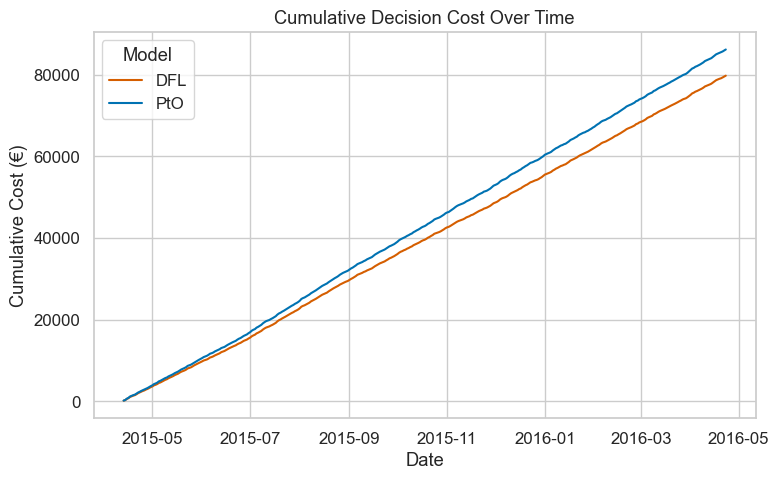

DFL cumulative cost reduction: 7.44%


In [43]:
sns.set_style("whitegrid")

def make_cumulative_cost(model_pto, model_dfl, layer, test_data, panel_clean, store, cu=3.0, co=1.0):
    model_pto.eval()
    model_dfl.eval()

    B_table = make_budget(panel_clean)
    B_val = torch.tensor(float(B_table.loc[store]), dtype=torch.float64)

    all_records = []

    for model_name, model in [("PtO", model_pto), ("DFL", model_dfl)]:
        daily_costs = []
        dates = []
        for Xi, yi, d in test_data:
            X_t = torch.tensor(Xi, dtype=torch.float64)
            y_t = torch.tensor(yi, dtype=torch.float64)
            d_hat = model(X_t).squeeze(-1)
            price_vec, cu_vec, co_vec = get_operational_params(panel_clean, store, d, cu, co)
            D_t = d_hat.unsqueeze(0)
            q_star, = layer(D_t, cu_vec, co_vec, price_vec, B_val)

            under = torch.clamp(y_t - q_star, min=0)
            over  = torch.clamp(q_star - y_t, min=0)
            cost = torch.sum(cu_vec * under + co_vec * over).item()

            daily_costs.append(cost)
            dates.append(d)

        cum_cost = np.cumsum(daily_costs)
        all_records.extend(
            {"Date": pd.to_datetime(dates[i]), "Model": model_name, "Cumulative_Cost": cum_cost[i]}
            for i in range(len(dates))
        )

    return pd.DataFrame(all_records).sort_values(["Date", "Model"])

def plot_cumulative_cost(df_time):
    plt.figure(figsize=(8,5))
    sns.lineplot(data=df_time, x="Date", y="Cumulative_Cost", hue="Model", palette=["#D55E00","#0072B2"])
    plt.title("Cumulative Decision Cost Over Time")
    plt.ylabel("Cumulative Cost (€)")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

store = "CA_1"
df_time = make_cumulative_cost(model_pto, model_dfl, layer, test_data, panel_clean, store)

plot_cumulative_cost(df_time)

final_pto = df_time.query("Model=='PtO'")["Cumulative_Cost"].iloc[-1]
final_dfl = df_time.query("Model=='DFL'")["Cumulative_Cost"].iloc[-1]
improvement = 100 * (final_pto - final_dfl) / final_pto
print(f"DFL cumulative cost reduction: {improvement:.2f}%")

### Sensitivity to c_u / c_o

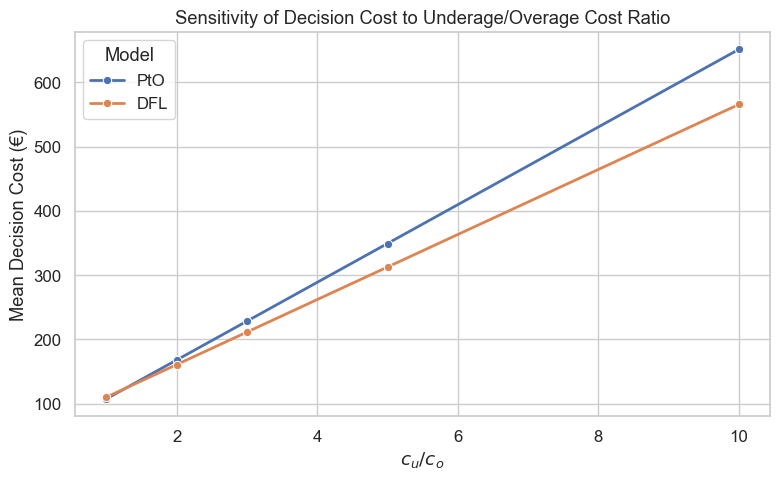


Sensitivity summary (lower cost is better):
 cu_over_co  Cost_PtO  Cost_DFL  DeltaCost_%(DFL_vs_PtO)
        1.0   107.643   110.299                    2.468
        2.0   168.059   160.892                   -4.265
        3.0   228.482   211.492                   -7.436
        5.0   349.315   312.693                  -10.484
       10.0   651.415   565.687                  -13.160


In [44]:

sns.set_style("whitegrid")

def make_sensitivity_cu_co(models, layer, test_data, panel_clean, store, cu_list=(1, 2, 3, 5, 10), co=1.0):

    records = []
    for cu in cu_list:
        for name, model in models.items():
            res = evaluate_decision_quality(model, layer, test_data, panel_clean, store, cu=cu, co=co)
            records.append({
                "Model": name,
                "cu_over_co": cu / co,
                "cu": cu,
                "co": co,
                "Mean_Cost": float(res["mean_cost"])
            })
    return pd.DataFrame(records)

def plot_sensitivity_cu_co(df_sens):
    plt.figure(figsize=(8,5))
    ax = sns.lineplot(
        data=df_sens,
        x="cu_over_co", y="Mean_Cost", hue="Model",
        marker="o", linewidth=2
    )
    ax.set_title("Sensitivity of Decision Cost to Underage/Overage Cost Ratio")
    ax.set_xlabel(r"$c_u / c_o$")
    ax.set_ylabel("Mean Decision Cost (€)")
    plt.tight_layout()
    plt.show()


cu_grid = (1, 2, 3, 5, 10)    
co_fixed = 1.0

df_sens = make_sensitivity_cu_co(
    models=models,
    layer=layer,
    test_data=test_data,
    panel_clean=panel_clean,
    store=store,
    cu_list=cu_grid,
    co=co_fixed
)

plot_sensitivity_cu_co(df_sens)


pt = df_sens.pivot_table(index="cu_over_co", columns="Model", values="Mean_Cost")
if {"PtO", "DFL"}.issubset(pt.columns):
    delta_pct = 100.0 * (pt["DFL"] - pt["PtO"]) / pt["PtO"]
    summary = pd.DataFrame({
        "cu_over_co": pt.index.values,
        "Cost_PtO": pt["PtO"].values,
        "Cost_DFL": pt["DFL"].values,
        "DeltaCost_%(DFL_vs_PtO)": delta_pct.values
    })
    summary = summary.sort_values("cu_over_co").reset_index(drop=True)
    print("\nSensitivity summary")
    print(summary.round(3).to_string(index=False))
else:
    print("error")